# Download dataset
to download the dataset, follow this link to Stanford's website https://stanfordaimi.azurewebsites.net/datasets/23c56a0d-15de-405b-87c8-99c30138950c
Now to load the gradcam heatmaps and overlays, run the following commented out cells. 
This is how you can use stanford's chexpert data for chest x-rays.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# To get saliency map of 1 image predicted by stanford university group
as present in this research paper: https://doi.org/10.1038/s42256-022-00536-x

Using GradCAM map: patient64541_study1_view1_frontal_Airspace Opacity_map.pkl
Resolved image path: /kaggle/input/chexpert/CheXpert/val/patient64541/study1/view1_frontal.jpg


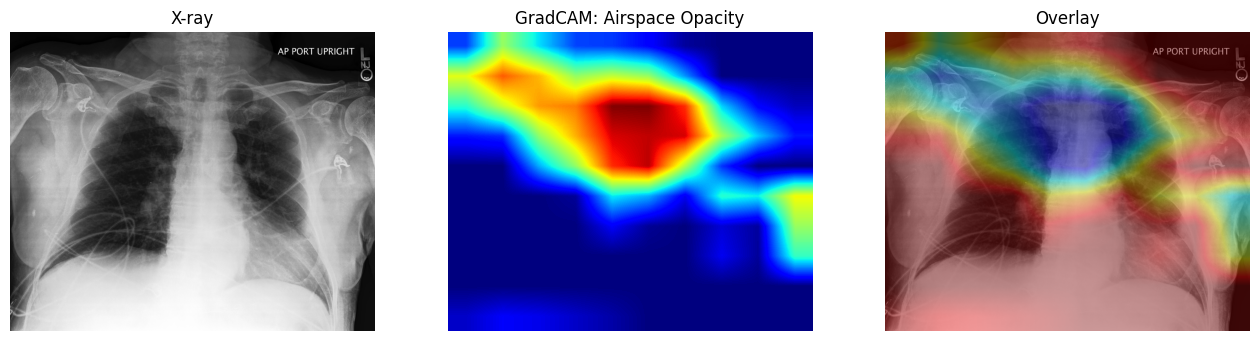

In [2]:
import os
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

# ==== PATHS ====
maps_root = "/kaggle/input/chexpert/chexLocalize/gradcam_maps_val"
img_root  = "/kaggle/input/chexpert/CheXpert/val"

# ==== LIST FILES ====
files = sorted([f for f in os.listdir(maps_root) if f.endswith(".pkl")])
fname = files[0]
print("Using GradCAM map:", fname)

# ==== PARSE FILENAME ====
basename = fname.replace("_map.pkl", "")
parts = basename.split("_")

patient    = parts[0]
study      = parts[1]
view       = parts[2]
projection = parts[3]
label      = " ".join(parts[4:])    # handles spaces

# IMAGE FILE
image_file = f"{view}_{projection}.jpg"
image_path = os.path.join(img_root, patient, study, image_file)

print("Resolved image path:", image_path)

# ==== LOAD IMAGE ====
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError("Image not found: " + image_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ==== LOAD GRAD-CAM PICKLE ====
with open(os.path.join(maps_root, fname), "rb") as f:
    data = pickle.load(f)

cam = data["map"]

# ---- FIX: convert torch tensor → numpy ----
if torch.is_tensor(cam):
    cam = cam.detach().cpu().numpy()

# ---- FIX: squeeze 4D → 2D ----
cam = cam.squeeze()      # (1,1,320,320) → (320,320)

# ---- convert to float ----
cam = cam.astype(float)

# ==== NORMALIZE ====
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

# ==== RESIZE CAM TO IMAGE SIZE ====
cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

# ==== HEATMAP ====
heat = cv2.applyColorMap((cam_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
overlay = (0.4 * heat + 0.6 * img).astype(np.uint8)

# ==== PLOT ====
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.title("X-ray")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title(f"GradCAM: {label}")
plt.imshow(cam_resized, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()

# To save saliency maps predicted by stanford people of all the images in the dataset

In [3]:
'''
import os
import pickle
import numpy as np
import cv2
import torch
from tqdm import tqdm

# ===== PATHS =====
maps_root = "/kaggle/input/chexpert/chexLocalize/gradcam_maps_val"
img_root  = "/kaggle/input/chexpert/CheXpert/val"
save_root = "/kaggle/working/chexpert_org/gradcam_overlay_results"

os.makedirs(save_root, exist_ok=True)

# ===== GET ALL MAP FILES =====
files = sorted([f for f in os.listdir(maps_root) if f.endswith(".pkl")])
print(f"Found {len(files)} saliency maps.\n")

# ===== LOOP THROUGH ALL MAP FILES =====
for fname in tqdm(files, desc="Generating GradCAM overlays"):

    try:
        # ---- Parse filename ----
        basename = fname.replace("_map.pkl", "")
        parts = basename.split("_")

        patient    = parts[0]
        study      = parts[1]
        view       = parts[2]
        projection = parts[3]
        label      = " ".join(parts[4:])

        # ---- Image path ----
        image_file = f"{view}_{projection}.jpg"
        image_path = os.path.join(img_root, patient, study, image_file)

        if not os.path.exists(image_path):
            print(f"[SKIPPED — Missing Image] {image_path}")
            continue

        # ---- Load image ----
        img = cv2.imread(image_path)
        if img is None:
            print(f"[SKIPPED — Image Load Failed] {image_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ---- Load GradCAM map ----
        try:
            with open(os.path.join(maps_root, fname), "rb") as f:
                data = pickle.load(f)
        except Exception as e:
            print(f"[SKIPPED — Failed to load pickle] {fname} | Error: {e}")
            continue

        # ---- Extract CAM ----
        cam = data.get("map", None)
        if cam is None:
            print(f"[SKIPPED — No 'map' key in CAM dict] {fname}")
            continue

        # ---- Convert tensor → numpy ----
        if torch.is_tensor(cam):
            cam = cam.detach().cpu().numpy()

        # ---- Squeeze 4D → 2D ----
        cam = cam.squeeze()
        if cam.ndim != 2:
            print(f"[SKIPPED — Invalid CAM shape {cam.shape}] {fname}")
            continue

        cam = cam.astype(float)

        # ---- Normalize ----
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        # ---- Resize CAM to image ----
        try:
            cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
        except Exception as e:
            print(f"[SKIPPED — Resize failed] {fname} | Error: {e}")
            continue

        # ---- Create overlay ----
        heat = cv2.applyColorMap((cam_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
        overlay = (0.4 * heat + 0.6 * img).astype(np.uint8)

        # ---- Save ----
        out_folder = os.path.join(save_root, patient, study)
        os.makedirs(out_folder, exist_ok=True)

        out_file = f"{view}_{projection}_{label.replace(' ', '_')}.png"
        save_path = os.path.join(out_folder, out_file)

        cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    except Exception as e:
        print(f"[SKIPPED — Unexpected Error] {fname} | Error: {e}")
'''

'\nimport os\nimport pickle\nimport numpy as np\nimport cv2\nimport torch\nfrom tqdm import tqdm\n\n# ===== PATHS =====\nmaps_root = "/kaggle/input/chexpert/chexLocalize/gradcam_maps_val"\nimg_root  = "/kaggle/input/chexpert/CheXpert/val"\nsave_root = "/kaggle/working/chexpert_org/gradcam_overlay_results"\n\nos.makedirs(save_root, exist_ok=True)\n\n# ===== GET ALL MAP FILES =====\nfiles = sorted([f for f in os.listdir(maps_root) if f.endswith(".pkl")])\nprint(f"Found {len(files)} saliency maps.\n")\n\n# ===== LOOP THROUGH ALL MAP FILES =====\nfor fname in tqdm(files, desc="Generating GradCAM overlays"):\n\n    try:\n        # ---- Parse filename ----\n        basename = fname.replace("_map.pkl", "")\n        parts = basename.split("_")\n\n        patient    = parts[0]\n        study      = parts[1]\n        view       = parts[2]\n        projection = parts[3]\n        label      = " ".join(parts[4:])\n\n        # ---- Image path ----\n        image_file = f"{view}_{projection}.jpg"\n  

# To save only heatmaps

In [4]:
'''
import os
import pickle
import numpy as np
import cv2
import torch
from tqdm import tqdm

# ===== PATHS =====
maps_root = "/kaggle/input/chexpert/chexLocalize/gradcam_maps_val"
img_root  = "/kaggle/input/chexpert/CheXpert/val"
save_root = "/kaggle/working/chexpert_org/gradcam_heat_results"

os.makedirs(save_root, exist_ok=True)

# ===== GET ALL MAP FILES =====
files = sorted([f for f in os.listdir(maps_root) if f.endswith(".pkl")])
print(f"Found {len(files)} GradCAM map .pkl files.\n")

# ===== LOOP THROUGH ALL MAP FILES =====
for fname in tqdm(files, desc="Saving raw GradCAM maps"):

    try:
        # ---- Parse filename ----
        basename = fname.replace("_map.pkl", "")
        parts = basename.split("_")

        patient    = parts[0]
        study      = parts[1]
        view       = parts[2]
        projection = parts[3]
        label      = " ".join(parts[4:])   # handles spaces

        # ---- Image path (for dimension reference) ----
        image_file = f"{view}_{projection}.jpg"
        image_path = os.path.join(img_root, patient, study, image_file)

        if not os.path.exists(image_path):
            print(f"[SKIPPED — Missing Image] {image_path}")
            continue

        img = cv2.imread(image_path)
        if img is None:
            print(f"[SKIPPED — Image Load Failed] {image_path}")
            continue

        H, W = img.shape[:2]

        # ---- Load GradCAM pkl ----
        try:
            with open(os.path.join(maps_root, fname), "rb") as f:
                data = pickle.load(f)
        except Exception as e:
            print(f"[SKIPPED — Failed to load pickle] {fname} | {e}")
            continue

        # ---- Extract map ----
        cam = data.get("map", None)
        if cam is None:
            print(f"[SKIPPED — No CAM key] {fname}")
            continue

        # ---- Convert torch → numpy ----
        if torch.is_tensor(cam):
            cam = cam.detach().cpu().numpy()

        # ---- Squeeze to 2D ----
        cam = cam.squeeze()
        if cam.ndim != 2:
            print(f"[SKIPPED — Invalid CAM shape] {fname} | Shape = {cam.shape}")
            continue

        cam = cam.astype(float)

        # ---- Normalize ----
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        # ---- Resize to match image size ----
        try:
            cam_resized = cv2.resize(cam, (W, H))
        except Exception as e:
            print(f"[SKIPPED — Resize failed] {fname} | {e}")
            continue

        # ---- Convert CAM to heatmap ----
        heatmap = cv2.applyColorMap((cam_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)

        # ---- Save path ----
        out_folder = os.path.join(save_root, patient, study)
        os.makedirs(out_folder, exist_ok=True)

        out_file = f"{view}_{projection}_{label.replace(' ', '_')}_heatmap.png"
        save_path = os.path.join(out_folder, out_file)

        # ---- Save heatmap ----
        cv2.imwrite(save_path, heatmap)

    except Exception as e:
        print(f"[SKIPPED — Unexpected Error] {fname} | {e}")
'''

'\nimport os\nimport pickle\nimport numpy as np\nimport cv2\nimport torch\nfrom tqdm import tqdm\n\n# ===== PATHS =====\nmaps_root = "/kaggle/input/chexpert/chexLocalize/gradcam_maps_val"\nimg_root  = "/kaggle/input/chexpert/CheXpert/val"\nsave_root = "/kaggle/working/chexpert_org/gradcam_heat_results"\n\nos.makedirs(save_root, exist_ok=True)\n\n# ===== GET ALL MAP FILES =====\nfiles = sorted([f for f in os.listdir(maps_root) if f.endswith(".pkl")])\nprint(f"Found {len(files)} GradCAM map .pkl files.\n")\n\n# ===== LOOP THROUGH ALL MAP FILES =====\nfor fname in tqdm(files, desc="Saving raw GradCAM maps"):\n\n    try:\n        # ---- Parse filename ----\n        basename = fname.replace("_map.pkl", "")\n        parts = basename.split("_")\n\n        patient    = parts[0]\n        study      = parts[1]\n        view       = parts[2]\n        projection = parts[3]\n        label      = " ".join(parts[4:])   # handles spaces\n\n        # ---- Image path (for dimension reference) ----\n    

The folder chexpert_org are the extracted saliency maps and overlay maps given in the dataset

# Now to get ground truth annotations depicting infection masks for human understanding. 

JSON Key: patient64541_study1_view1_frontal


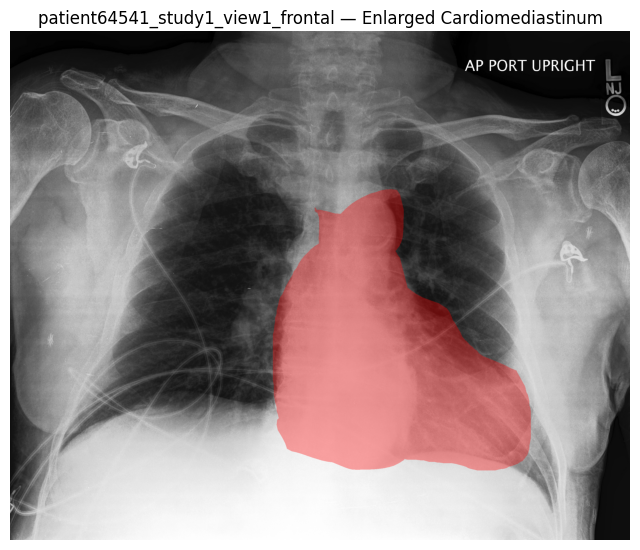

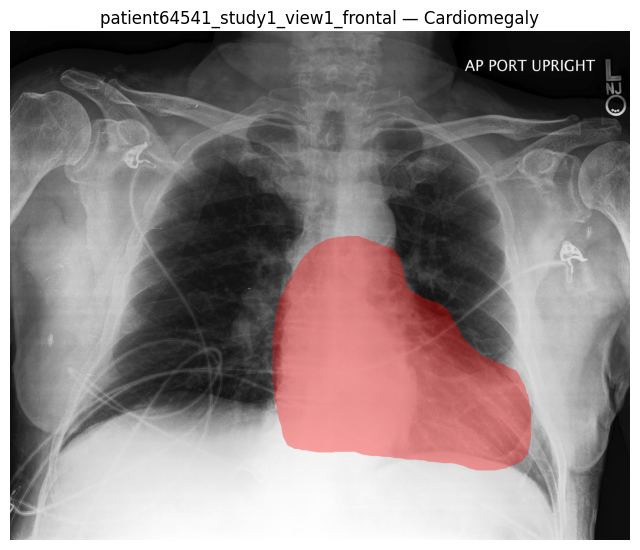

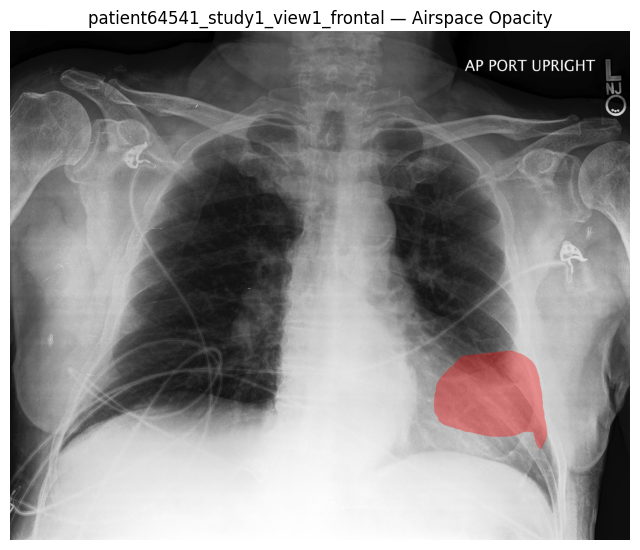

In [5]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ====== PATHS ======
json_path = "/kaggle/input/chexpert/chexLocalize/gt_annotations_val.json"
img_path  = "/kaggle/input/chexpert/CheXpert/val/patient64541/study1/view1_frontal.jpg"

# ====== BUILD JSON KEY FROM IMAGE PATH ======
parts = img_path.split("/")
patient = parts[-3]                      # patient64541
study   = parts[-2]                      # study1
view    = parts[-1].replace(".jpg", "")  # view1_frontal

img_id = f"{patient}_{study}_{view}"
print("JSON Key:", img_id)

# ====== LOAD JSON ======
with open(json_path, "r") as f:
    data = json.load(f)

if img_id not in data:
    raise KeyError(f"{img_id} not found in JSON!")

ann = data[img_id]

# ====== LOAD IMAGE ======
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ====== FOR EACH CLASS, DISPLAY ITS OWN ANNOTATION ======
for cls_name, polygons in ann.items():

    if cls_name == "img_size":
        continue

    overlay = img.copy()

    for polygon in polygons:
        pts = np.array(polygon, dtype=np.int32).reshape((-1,1,2))

        # draw only this class
        cv2.polylines(overlay, [pts], True, (255, 0, 0), 3)
        cv2.fillPoly(overlay, [pts], (255, 0, 0))

    # Blend with transparency
    alpha = 0.35
    output = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

    # DISPLAY IN NOTEBOOK
    plt.figure(figsize=(8,8))
    plt.imshow(output)
    plt.title(f"{img_id} — {cls_name}")
    plt.axis("off")
    plt.show()


JSON Key: patient64541_study1_view1_frontal


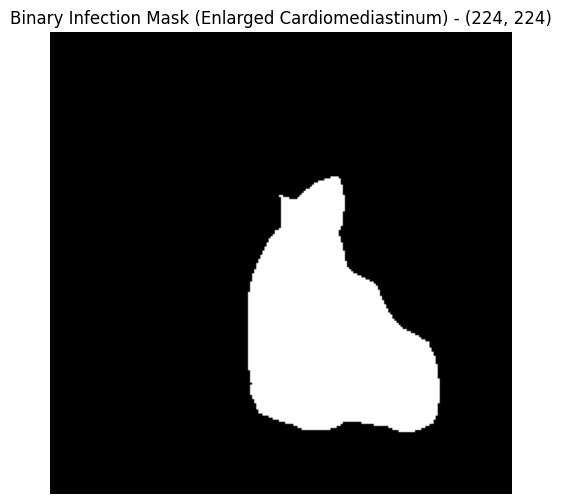

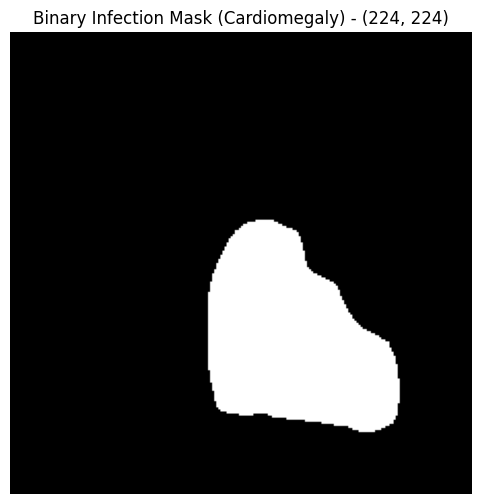

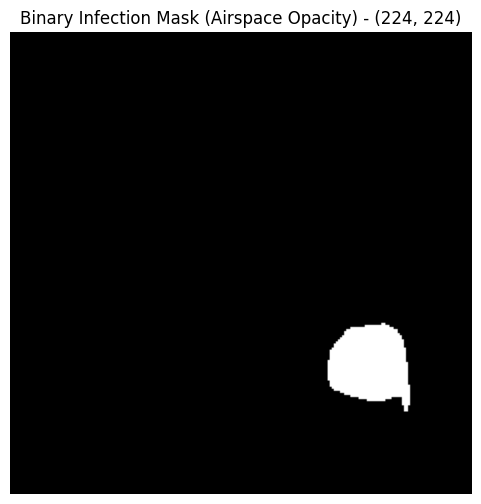

In [6]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ====== PATHS ======
json_path = "/kaggle/input/chexpert/chexLocalize/gt_annotations_val.json"
img_path  = "/kaggle/input/chexpert/CheXpert/val/patient64541/study1/view1_frontal.jpg"

# ====== MODEL INPUT SIZE ======
target_size = (224, 224)   # change this to your model's expected mask size

# ====== BUILD JSON KEY FROM IMAGE PATH ======
parts = img_path.split("/")
patient = parts[-3]                      
study   = parts[-2]                      
view    = parts[-1].replace(".jpg", "")  

img_id = f"{patient}_{study}_{view}"
print("JSON Key:", img_id)

# ====== LOAD JSON ======
with open(json_path, "r") as f:
    data = json.load(f)

ann = data[img_id]

# ====== LOAD IMAGE ======
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w = img.shape[:2]

# ====== FOR EACH CLASS, CREATE BINARY MASK ======
for cls_name, polygons in ann.items():

    if cls_name == "img_size":
        continue

    # -------------------------
    # Create binary mask
    # -------------------------
    mask = np.zeros((h, w), dtype=np.uint8)   # all black = 0

    for polygon in polygons:
        pts = np.array(polygon, dtype=np.int32).reshape((-1,1,2))
        cv2.fillPoly(mask, [pts], 255)        # fill region = 255 (white)

    # -------------------------
    # Resize mask to model size
    # -------------------------
    resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

    # Ensure mask is strictly 0 or 255
    resized_mask = (resized_mask > 127).astype(np.uint8) * 255

    # -------------------------
    # SHOW MASK
    # -------------------------
    plt.figure(figsize=(6,6))
    plt.imshow(resized_mask, cmap="gray")
    plt.title(f"Binary Infection Mask ({cls_name}) - {target_size}")
    plt.axis("off")
    plt.show()

# Now to get ground truth annotations depicting infection masks for machine understanding. 

Difference from above images: For machine serving images are drafted with less pixel details whereas these images coming after this cell are those with high pixel annotations for a machine

JSON Key: patient64541_study1_view1_frontal


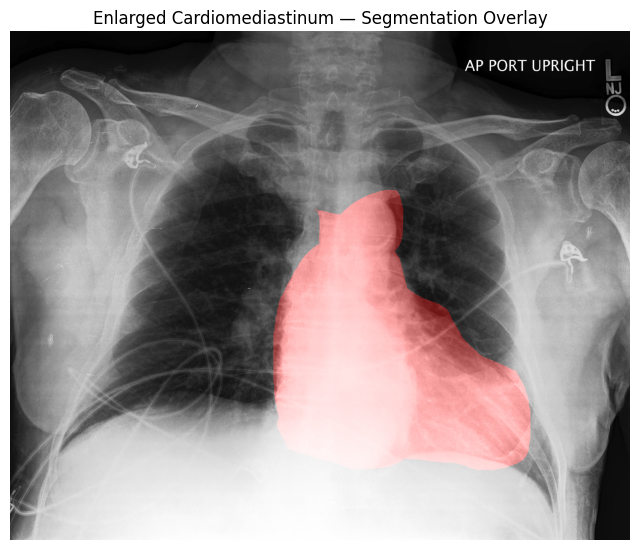

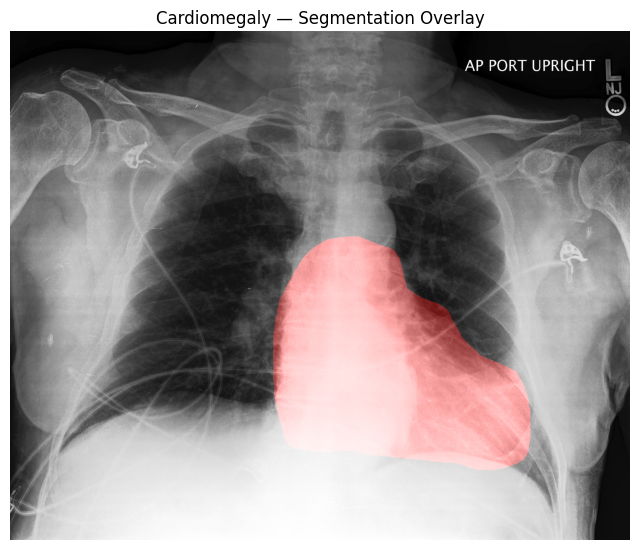

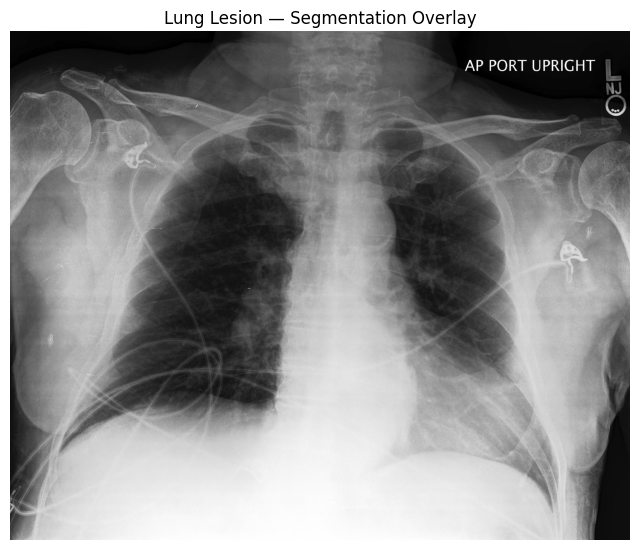

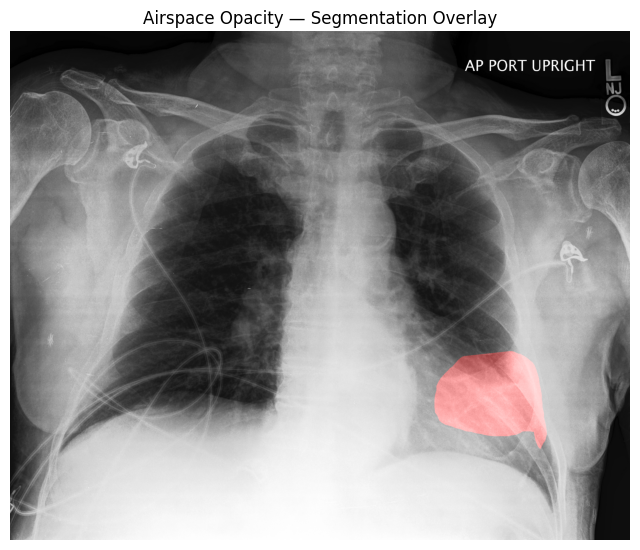

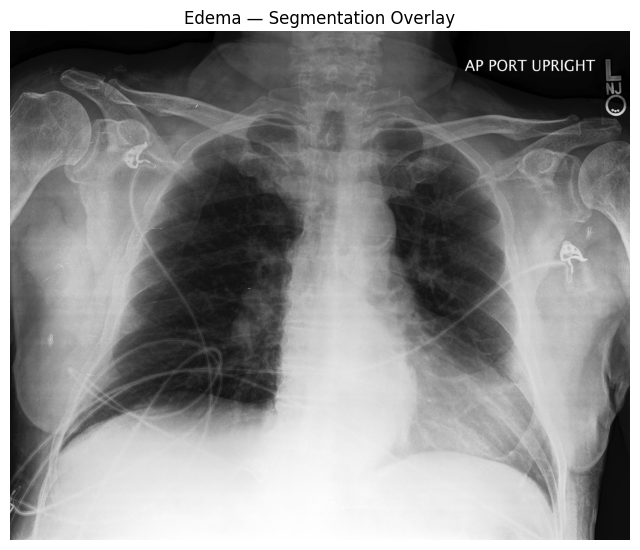

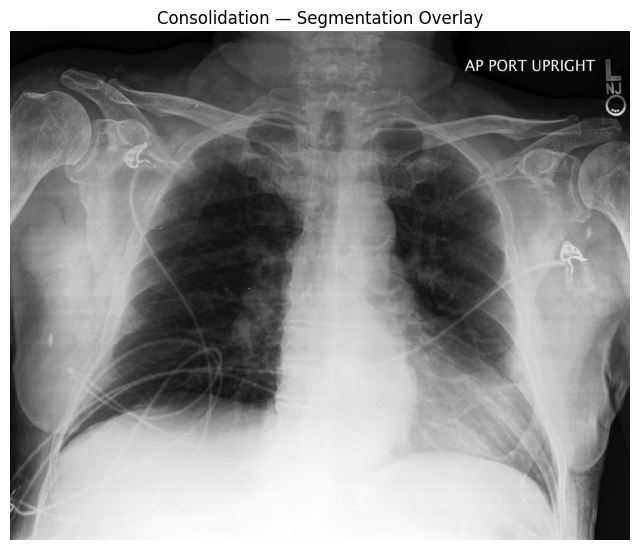

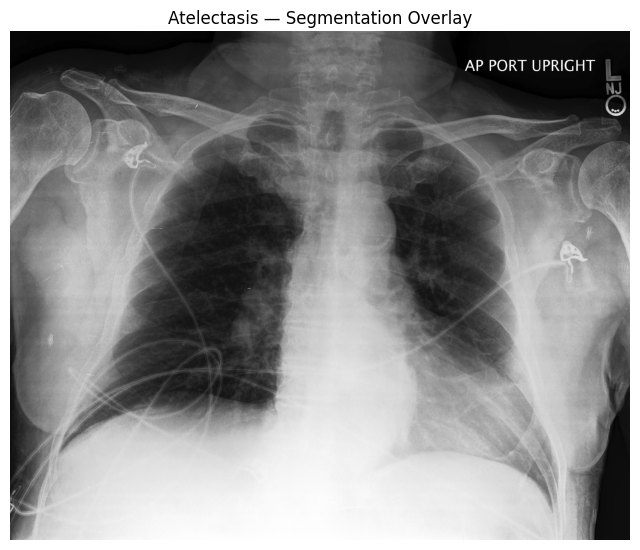

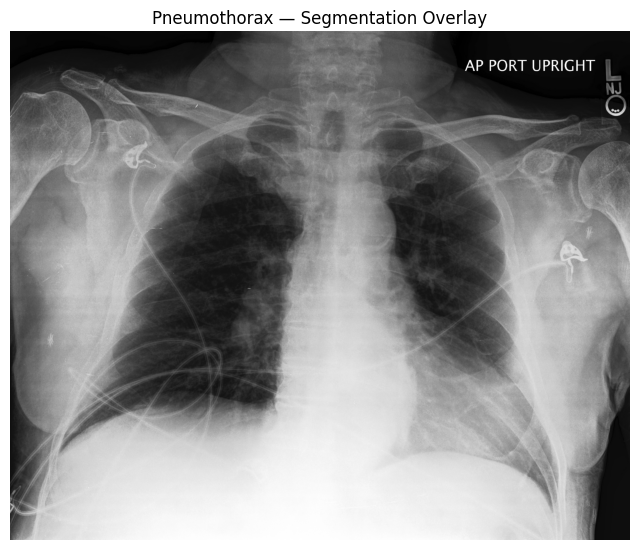

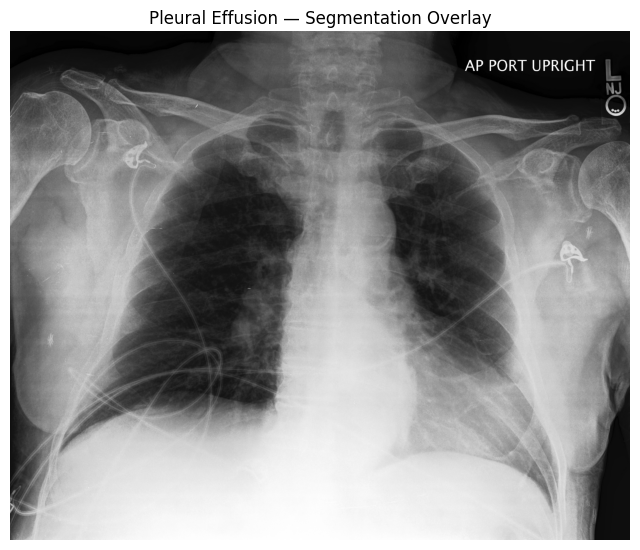

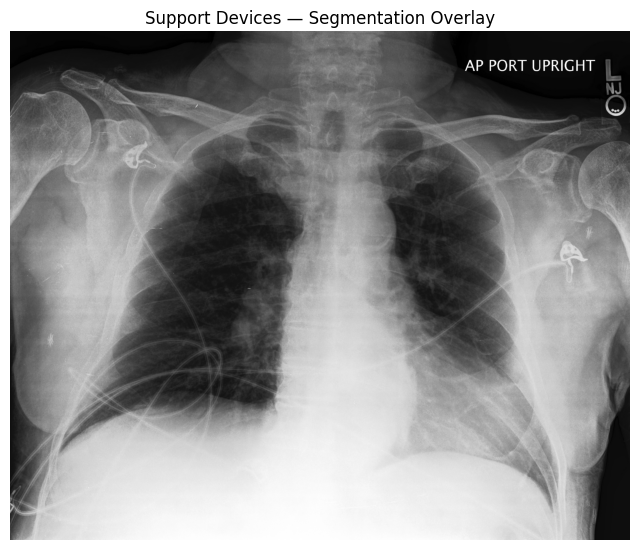

In [7]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ========= PATHS =========
json_path = "/kaggle/input/chexpert/chexLocalize/gt_segmentations_val.json"
img_path  = "/kaggle/input/chexpert/CheXpert/val/patient64541/study1/view1_frontal.jpg"

# ========= BUILD JSON KEY =========
parts = img_path.split("/")
patient = parts[-3]                      # patient64541
study   = parts[-2]                      # study1
view    = parts[-1].replace(".jpg", "")  # view1_frontal
img_id  = f"{patient}_{study}_{view}"

print("JSON Key:", img_id)

# ========= LOAD JSON =========
with open(json_path, "r") as f:
    data = json.load(f)

ann = data[img_id]    # segmentations for this image


# ========= RLE DECODING FUNCTION =========
def rle_decode(rle, shape):
    """Decodes COCO-style RLE to binary mask."""
    s = rle["counts"]
    
    # Convert compressed RLE strings into uncompressed form
    if isinstance(s, list):
        # Uncompressed RLE
        counts = s
    else:
        # Compressed RLE -> use pycocotools method
        import pycocotools.mask as mask_utils
        return mask_utils.decode(rle).astype(np.uint8)
    
    h, w = shape
    mask = np.zeros(h * w, dtype=np.uint8)
    idx = 0
    val = 0

    for count in counts:
        mask[idx:idx+count] = val
        idx += count
        val = 1 - val

    mask = mask.reshape((h, w), order="F")
    return mask


# ========= LOAD IMAGE =========
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# ========= DISPLAY OVERLAY FOR EACH CLASS =========
for cls_name, rle in ann.items():

    if cls_name == "img_size":
        continue

    # Decode segmentation mask
    mask = rle_decode(rle, (h, w))   # binary 0/1 mask

    # Convert to 255 white mask
    mask_255 = (mask * 255).astype(np.uint8)

    # Create red overlay
    red_overlay = np.zeros_like(img)
    red_overlay[:, :, 0] = mask_255   # red channel

    # Blend overlay on image
    alpha = 0.35
    overlay = cv2.addWeighted(img, 1, red_overlay, alpha, 0)

    # Show in notebook
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    plt.title(f"{cls_name} — Segmentation Overlay")
    plt.axis("off")
    plt.show()

JSON Key: patient64541_study1_view1_frontal


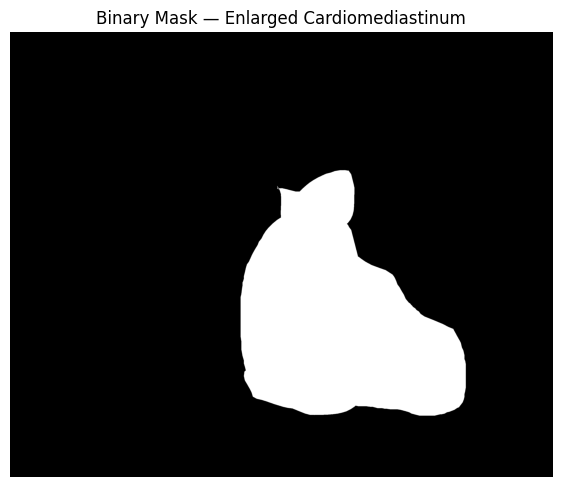

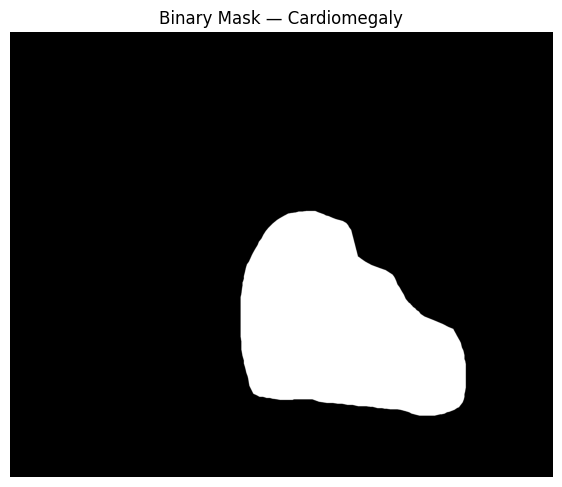

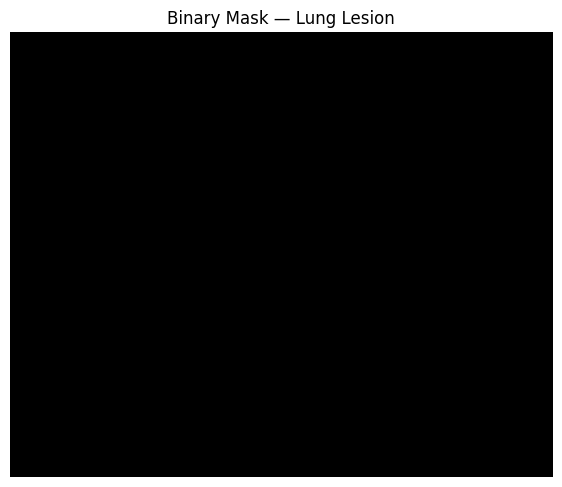

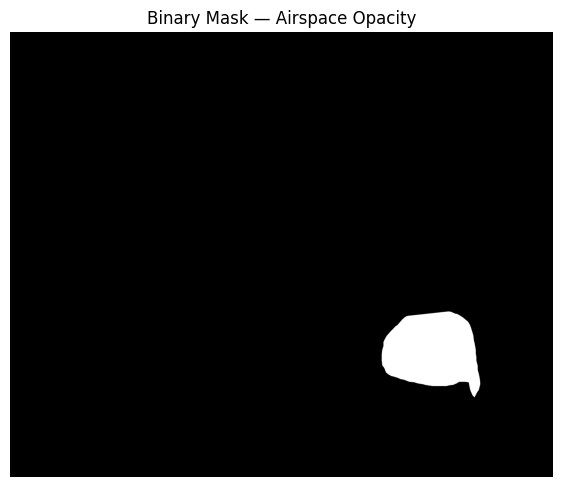

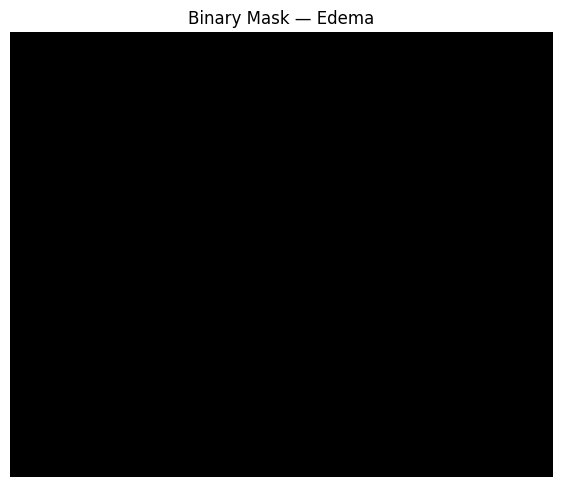

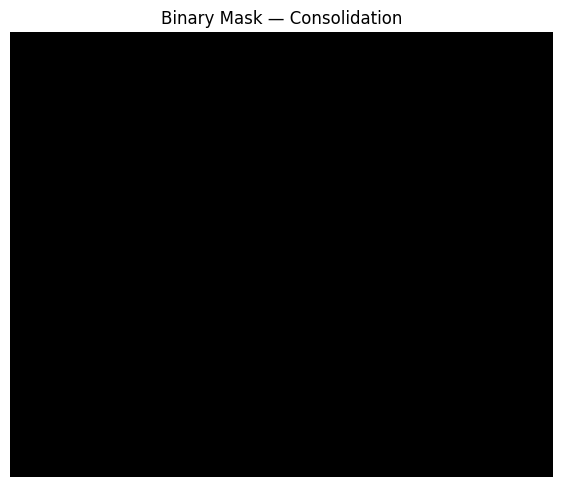

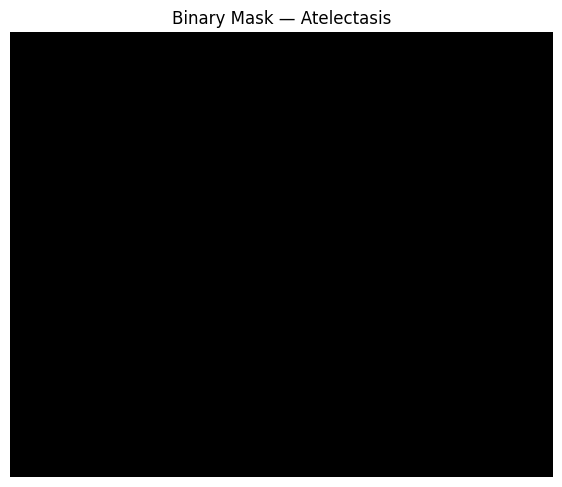

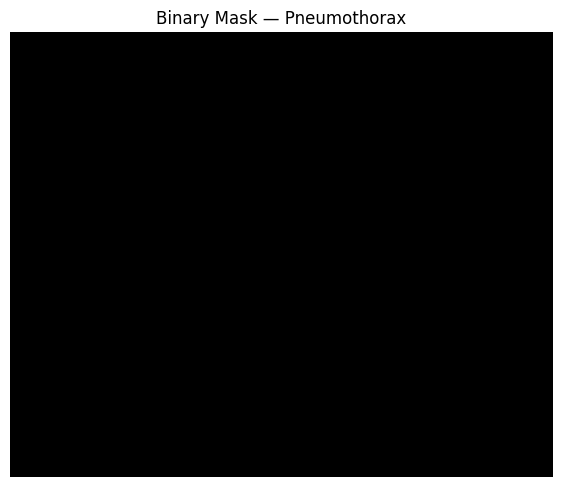

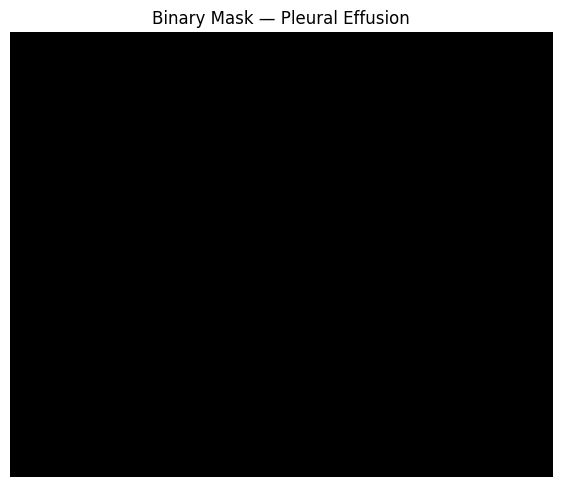

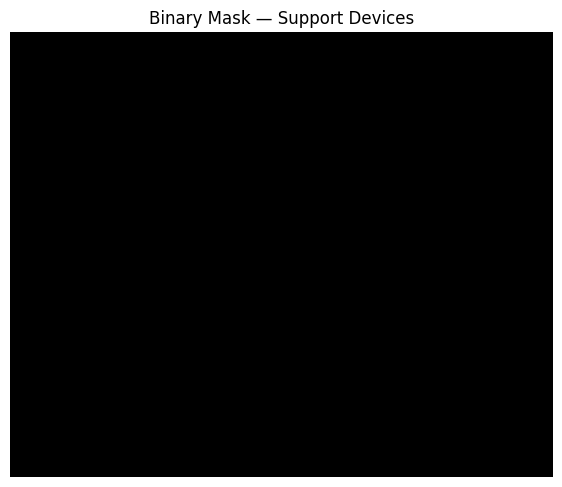

In [8]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ====== PATHS ======
json_path = "/kaggle/input/chexpert/chexLocalize/gt_segmentations_val.json"
img_path  = "/kaggle/input/chexpert/CheXpert/val/patient64541/study1/view1_frontal.jpg"

# ====== BUILD JSON KEY ======
parts = img_path.split("/")
patient = parts[-3]
study   = parts[-2]
view    = parts[-1].replace(".jpg", "")

img_id = f"{patient}_{study}_{view}"
print("JSON Key:", img_id)

# ====== LOAD JSON ======
with open(json_path, "r") as f:
    data = json.load(f)

ann = data[img_id]

# ====== LOAD IMAGE FOR SIZE ======
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]


# ====== RLE DECODER ======
def rle_decode(rle, shape):
    import pycocotools.mask as mask_utils

    # pycocotools decodes RLE into 0/1 mask
    mask = mask_utils.decode(rle)
    return mask.astype(np.uint8)


# ====== GENERATE & PRINT BINARY MASKS ======
for cls_name, rle in ann.items():

    if cls_name == "img_size":
        continue

    # Decode mask (0/1)
    mask = rle_decode(rle, (h, w))

    # Convert to binary 0/255
    binary_mask = (mask * 255).astype(np.uint8)

    # SHOW MASK
    plt.figure(figsize=(7, 7))
    plt.imshow(binary_mask, cmap="gray")
    plt.title(f"Binary Mask — {cls_name}")
    plt.axis("off")
    plt.show()


In [9]:
import json
import os
import cv2
import numpy as np
from tqdm import tqdm
import pycocotools.mask as mask_utils

# ========= PATHS =========
SEG_JSON = "/kaggle/input/chexpert/chexLocalize/gt_segmentations_val.json"
IMG_ROOT = "/kaggle/input/chexpert/CheXpert/val"
OUT_ROOT = "/kaggle/working/infection_masks_val"
TARGET_SIZE = (224, 224)

os.makedirs(OUT_ROOT, exist_ok=True)

# ========= LOAD JSON =========
with open(SEG_JSON, 'r') as f:
    seg_data = json.load(f)

print("Total annotated images:", len(seg_data))


# ========= FUNCTION: RLE TO BINARY MASK =========
def rle_to_mask(rle):
    """Convert RLE into a 0/1 numpy array mask."""
    mask = mask_utils.decode(rle)  # returns H×W with 0/1
    return mask.astype(np.uint8)


# ========= PROCESS EACH IMAGE =========
for img_id, classes in tqdm(seg_data.items(), desc="Processing images"):

    # skip img_size entry
    if img_id == "img_size":
        continue

    # Parse key: patientXXXXX_studyX_view1_frontal
    patient, study, view = img_id.split("_", 2)

    # Build image path
    img_path = os.path.join(IMG_ROOT, patient, study, view + ".jpg")

    # Make sure the image exists
    if not os.path.exists(img_path):
        print("Missing image:", img_path)
        continue

    # Load image to get original dimensions
    img = cv2.imread(img_path)
    if img is None:
        print("Failed to load:", img_path)
        continue

    H, W = img.shape[:2]

    # Output folder structure
    save_dir = os.path.join(OUT_ROOT, patient, study)
    os.makedirs(save_dir, exist_ok=True)

    # Process each class mask
    for cls_name, rle in classes.items():

        if cls_name == "img_size":
            continue

        # Decode mask → 0/1
        mask = rle_to_mask(rle)

        # Ensure correct size and binary format
        assert mask.shape == (H, W)

        # Resize to model size with nearest-neighbor
        mask_resized = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)

        # Convert to 0/255 binary image
        mask_binary = (mask_resized * 255).astype(np.uint8)

        # Save path
        save_path = os.path.join(save_dir, f"{view}_{cls_name}.png")

        # Save binary mask
        cv2.imwrite(save_path, mask_binary)

Total annotated images: 187


Processing images: 100%|██████████| 187/187 [00:45<00:00,  4.07it/s]


# Save the infection masks created

In [10]:
import json
import os
import cv2
import numpy as np
from tqdm import tqdm
import pycocotools.mask as mask_utils

# ========= PATHS =========
SEG_JSON = "/kaggle/input/chexpert/chexLocalize/gt_segmentations_test.json"
IMG_ROOT = "/kaggle/input/chexpert/CheXpert/test"
OUT_ROOT = "/kaggle/working/infection_masks_test"
TARGET_SIZE = (224, 224)

os.makedirs(OUT_ROOT, exist_ok=True)

# ========= LOAD JSON =========
with open(SEG_JSON, 'r') as f:
    seg_data = json.load(f)

print("Total annotated test images:", len(seg_data))


# ========= FUNCTION: RLE TO BINARY MASK =========
def rle_to_mask(rle):
    """Convert RLE into a 0/1 numpy array mask."""
    mask = mask_utils.decode(rle)  # returns H×W array
    return mask.astype(np.uint8)


# ========= PROCESS EACH IMAGE =========
for img_id, classes in tqdm(seg_data.items(), desc="Processing TEST images"):

    # skip img_size entry (not needed)
    if img_id == "img_size":
        continue

    # Parse key: patientXXXX_studyY_viewX_frontal
    patient, study, view = img_id.split("_", 2)

    # Build image path
    img_path = os.path.join(IMG_ROOT, patient, study, view + ".jpg")

    # Confirm file exists
    if not os.path.exists(img_path):
        print("Missing image:", img_path)
        continue

    # Load image: needed for the original size H, W
    img = cv2.imread(img_path)
    if img is None:
        print("Failed to load:", img_path)
        continue

    H, W = img.shape[:2]

    # Create output directory for patient/study
    save_dir = os.path.join(OUT_ROOT, patient, study)
    os.makedirs(save_dir, exist_ok=True)

    # Process each class
    for cls_name, rle in classes.items():

        if cls_name == "img_size":
            continue

        # Decode mask (binary 0/1)
        mask = rle_to_mask(rle)

        # Sanity check size
        assert mask.shape == (H, W), f"Mask size mismatch for {img_id}"

        # Resize to model size (224x224)
        mask_resized = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)

        # Convert to pure binary 0/255
        mask_binary = (mask_resized * 255).astype(np.uint8)

        # Build save path
        save_path = os.path.join(save_dir, f"{view}_{cls_name}.png")

        # Save mask
        cv2.imwrite(save_path, mask_binary)

Total annotated test images: 499


Processing TEST images: 100%|██████████| 499/499 [01:51<00:00,  4.48it/s]


In [11]:
import shutil

# Folders you previously created
val_dir  = "/kaggle/working/infection_masks_val"
test_dir = "/kaggle/working/infection_masks_test"

# Output zip file names
val_zip_path  = "/kaggle/working/infection_masks_val.zip"
test_zip_path = "/kaggle/working/infection_masks_test.zip"

# Zip both folders
shutil.make_archive(val_zip_path.replace(".zip",""), 'zip', val_dir)
shutil.make_archive(test_zip_path.replace(".zip",""), 'zip', test_dir)

print("Zipping completed!")
print("Saved:", val_zip_path)
print("Saved:", test_zip_path)

Zipping completed!
Saved: /kaggle/working/infection_masks_val.zip
Saved: /kaggle/working/infection_masks_test.zip
